# LV5: End-to-End Speech-to-Text Summarization / Topic Modeling

---



## 1. Uvod u automatsko prepoznavanje govora

Pretvorba govora u tekst (Speech-to-text) jedna je od osnovnih metoda u kontekstu obrade prirodnog jezika. Automatsko prepoznavanje govora - ASR pretvara dani govor u pisani tekst.
U aktualnim vremenima velika količina informacija dostupna u raznim izvorima može se činiti prekomjerom pa se pojavljuje i potreba za sažimanjem, što onda dodatno otežava problem s obzirom da je potrebno održati temeljne poruke i značanje govora kroz proces sažimanja.
Modeliranje tema (topic modeling) metoda je koja se oslanja na nenadzirano strojno učenje tj. grupiranje podataka koji su u ovom slučaju riječi u sklopu nekog odlomka ili teme. Na temelju danog teksta model pokušava odrediti neke česte motive koji su prisutni u odlomku i na taj način odrediti temu odlomka.

### Svrha ove vježbe biti će provesti studente kroz proces pretvorbe govora u tekst i sve korake koji su prisutni u tom procesu

## 2. Priprema potrebnih biblioteka

In [1]:
!pip install SpeechRecognition pydub nltk gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 15.2 MB/s eta 0:00:00


Objašnjenje instaliranih biblioteka:
  - SpeechRecognition je biblioteka za pretvorbu govora u tekst
  - pydub je biblioteka za obradu i upravljanje zvučnim zapisima
  - nltk smo koristili u prethodnim vježbama, koristi se za provođenje metoda obrade prirodnog jezika nad tekstom

In [2]:
import speech_recognition as sr
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 3. Preuzimanje, učitavanje audio uzoraka i pretvorba u govor

U svrhu jednostavnosti pripremili smo nekoliko kratkotrajnih audio uzoraka koje će te koristit u ovim vježbama, trebali bi biti dostupni na Merlinu na istom mjestu kao i predložak ove bilježnice.  

Google Colab nije u mogućnosti odjednom obraditi audio uzorke koji se koriste u sklopu ovih laboratorijskih vježbi, budući da njihovo trajanje premašuje dopuštena ograničenja sustava. Zbog toga je audio zapise potrebno podijeliti na manje cjeline u trajanju od 30 sekundi.

U nastavku je dana funkcija za učitavanje audio uzorka koja automatski dijeli zapis na 30-sekundne cjeline, provodi prepoznavanje govora za svaku pojedinu cjelinu te na kraju sve prepoznate tekstove objedinjuje u jedan konačni rezultat.

Ovu funkciju koristite za učitavanje audio uzoraka, kako bih se izvukao tekst iz njih

In [4]:
recognizer = sr.Recognizer()
def transcribe_audio_in_chunks(
    audio_file,
    recognizer,
    chunk_duration=30,
    language="en-US"
):
    texts = []

    with sr.AudioFile(audio_file) as source:
        while True:
            audio = recognizer.record(source, duration=chunk_duration)

            if len(audio.frame_data) == 0:
                break

            try:
                text = recognizer.recognize_google(audio, language=language)
                texts.append(text)
            except sr.UnknownValueError:
                print("Speech Recognition could not understand audio in this segment.")
            except sr.RequestError as e:
                print(
                    f"Could not request results from Google Speech Recognition service; {e}"
                )

    return " ".join(texts)

In [5]:
audio_file = "sample_clip.wav"
text = transcribe_audio_in_chunks(audio_file, recognizer)
print(text)

his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we glanced at him stealthily over the tops of our slates the next day in school he knew we were watching him and made sundry mouths


## Nakon što je prepoznavanje dovršeno nakratko se osvrnite na rezultat.
## Napomene:  
Manjak interpunkcije je normalan kao i povremeno krivo prepoznavanje riječi pogotovo ako imamo nekoliko riječi koje se isto izgovaraju  
## Za ovaj primjer imamo shallow što bi trebalo biti sallow, piše se drugačije, ali je u govoru efektivno ista stvar

## Podzadatak:  
S obzirom da je pretvorba uklonila sve oblike strukture i rečenica, a izvorne vrijednosti ne znate potrebno je obnoviti rečenice.  
To ćete učiniti sami, točan odgovor bio bi onaj koji je definiran u početnom uzorku, ali ne morate previše misliti o tome, razlike u odabiru dati će različite rezultate.  
  
Dana metoda radi fiksno razdvajanje na podrečenice s obzirom na odabranu duljinu, možete koristiti nju ili pješke definirati rečenice. Ako koristite danu metodu slobodno isprobavajte drugačije duljine.

In [6]:
def split_into_sentences(text, sentence_length=20):
    words = text.split()
    sentences = []

    for i in range(0, len(words), sentence_length):
        sentence = " ".join(words[i:i+sentence_length])
        sentences.append(sentence)

    return sentences

In [7]:
sentences = split_into_sentences(text)
sentences[:3]

['his red hair seemed to change to a lively red and his shallow cheeks to a deeper sallow as we',
 'glanced at him stealthily over the tops of our slates the next day in school he knew we were watching',
 'him and made sundry mouths']

## 4. Predobrada dobivenog teksta  
Dobiveni rezultat potrebno je urediti i pripremiti za korištenje u NLP metodama, veliki dio toga već je spomenut u prethodnim vježbama  
Koraci:
  - Pretvoriti sve u mala slova (ako već nije)
  - Ukloniti znakove koji nisu slova
  - Odraditi tokenizaciju
  - Ukloniti stop riječi
  - Odraditi lematizaciju


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s]', '', sentence)
    tokens = nltk.word_tokenize(sentence)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return tokens

In [9]:
tokenized_sentences = [preprocess_sentence(s) for s in sentences]
tokenized_sentences[:3]

[['red',
  'hair',
  'seemed',
  'change',
  'lively',
  'red',
  'shallow',
  'cheek',
  'deeper',
  'sallow'],
 ['glanced',
  'stealthily',
  'top',
  'slate',
  'next',
  'day',
  'school',
  'knew',
  'watching'],
 ['made', 'sundry', 'mouth']]

### Zadatak 1

1. Učitajte i pretvorite u tekst **drugi audio uzorak**
   (`clip2.wav`)
2. Promotritet rezultat i samostalno definirajte rečenice
3. Ponovite postupak obrade i tokenizacije teksta

In [22]:
audio_file = "clip2.wav"
text = transcribe_audio_in_chunks(audio_file, recognizer)
print(text)



Speech Recognition could not understand audio in this segment.
real estate for the closed and open session to review the evidence in Mr older ones case is charged with murder conspiracy to murder conspiracy to cause explosions and possession of explosives before we begin we need to establish the order of today's proceedings I would suggest my lawyer that we begin with the opening material and the prosecution I have no preference but I always believed these matters the best left to the wisdom and discretion of the bench we will begin with the clothes materials wig shop we are now in close the crown argue that this evidence should not be disclosed to the defense in the interests of National Security it will be presented for the benefits of the special Advocate I understand that you wish to cross-examine the security service witness whom we will call witnesses of operations think happy thoughts will you confirmed to the special Advocate the identity of the informant the informant is Mr Ed

In [23]:
tokenized_sentences = [preprocess_sentence(s) for s in split_into_sentences(text)]
tokenized_sentences[:3]

[['real',
  'estate',
  'closed',
  'open',
  'session',
  'review',
  'evidence',
  'mr',
  'older',
  'one',
  'case',
  'charged'],
 ['murder',
  'conspiracy',
  'murder',
  'conspiracy',
  'cause',
  'explosion',
  'possession',
  'explosive',
  'begin',
  'need',
  'establish'],
 ['order',
  'today',
  'proceeding',
  'would',
  'suggest',
  'lawyer',
  'begin',
  'opening',
  'material',
  'prosecution']]

Sentance 1 :
The real estate case was reviewed in a closed session, where evidence showed that Mr. Older was the one charged in the open hearing.

Sentance 2 :
 The murder conspiracy case began after investigators established the cause as an explosion involving possession of an explosive.

Sentance 3 :
In today’s proceeding, the lawyer suggested the prosecution begin opening material in order to move forward.

In [20]:
dictionary = corpora.Dictionary(tokenized_sentences)

corpus = [dictionary.doc2bow(text) for text in tokenized_sentences]

print(f"Broj jedinstvenih tokena: {len(dictionary)}")
print(f"Broj dokumenata (rečenica): {len(corpus)}")

Broj jedinstvenih tokena: 117
Broj dokumenata (rečenica): 16


## 5. Modeliranje tema (Topic Modeling)

Sada kada imamo obrađen tekst, možemo primijeniti metodu modeliranja tema. Koristit ćemo **Latent Dirichlet Allocation (LDA)**, popularan algoritam koji pretpostavlja da se svaki dokument sastoji od mješavine tema, a svaka tema od mješavine riječi.

Za ovu svrhu koristit ćemo biblioteku `gensim`.

In [10]:
import gensim
from gensim import corpora

audio_file = "clip1.wav"

text = transcribe_audio_in_chunks(audio_file, recognizer)
tokenized_sentences = [preprocess_sentence(s) for s in split_into_sentences(text)]

# Kreiranje rječnika (mapiranje riječi u ID)
dictionary = corpora.Dictionary(tokenized_sentences)

# Kreiranje korpusa: Bag-of-Words reprezentacija
corpus = [dictionary.doc2bow(text) for text in tokenized_sentences]

print(f"Broj jedinstvenih tokena: {len(dictionary)}")
print(f"Broj dokumenata (rečenica): {len(corpus)}")

Speech Recognition could not understand audio in this segment.
Speech Recognition could not understand audio in this segment.
Speech Recognition could not understand audio in this segment.
Broj jedinstvenih tokena: 80
Broj dokumenata (rečenica): 8


### Treniranje LDA modela

Trenirat ćemo model da pronađe određeni broj tema (npr. 3). U stvarnom svijetu, broj tema se često određuje eksperimentalno ili pomoću mjere koherencije.

In [11]:
# Postavljanje parametara
num_topics = 3
passes = 10 # Broj prolaza kroz korpus

# Kreiranje i treniranje LDA modela
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=passes,
                                   alpha='auto',
                                   per_word_topics=True)

### Prikaz rezultata

Ispisat ćemo ključne riječi za svaku pronađenu temu. Svaka riječ ima pridruženu vjerojatnost koja govori koliko je ta riječ značajna za tu temu.

In [12]:
# Ispis tema
for idx, topic in lda_model.print_topics(-1):
    print(f"Tema: {idx} \nKljučne riječi: {topic}\n")

Tema: 0 
Ključne riječi: 0.013*"jose" + 0.013*"portugal" + 0.013*"navigate" + 0.013*"erati" + 0.013*"santos" + 0.013*"cup" + 0.013*"open" + 0.013*"qualified" + 0.013*"red" + 0.013*"led"

Tema: 1 
Ključne riječi: 0.036*"coach" + 0.035*"ronaldo" + 0.020*"italian" + 0.020*"official" + 0.020*"league" + 0.020*"feeling" + 0.020*"champion" + 0.020*"deposed" + 0.020*"unveiled" + 0.020*"he"

Tema: 2 
Ključne riječi: 0.041*"portugal" + 0.029*"ronaldo" + 0.029*"world" + 0.029*"official" + 0.029*"cup" + 0.029*"jose" + 0.016*"regularly" + 0.016*"qualifying" + 0.016*"used" + 0.016*"dash"



### Što je mjera koherencije (Coherence Score)?

Mjera koherencije koristi se za procjenu kvalitete tema dobivenih modeliranjem. Teme su "koherentne" ako su riječi koje ih čine semantički slične i često se pojavljuju zajedno u istom kontekstu. Ljudi lakše interpretiraju teme s visokom koherencijom.

Postoji više mjera, a u zadatku ispod koristit ćemo **c_v**.
- **c_v mjera** kombinira nekoliko tehnika (sliding window, normalized pointwise mutual information - NPMI, cosine similarity) kako bi ocijenila koliko su top riječi neke teme međusobno povezane.
- **Vrijednosti:** Kreću se od 0 do 1. Veća vrijednost znači bolju, interpretabilniju temu.
- **Cilj:** Pronaći broj tema koji maksimizira ovu vrijednost. Međutim, treba paziti da se ne odabere prevelik broj tema samo zbog blagog rasta koherencije, jer teme mogu postati previše specifične. Tražimo "lakat" (elbow) na grafu ili točku gdje rast usporava.

### Zadatak 2 - Optimizacija LDA modela

Umjesto ručnog pogađanja broja tema, u ovom zadatku ćete koristiti mjeru **koherencije (Coherence Score)** za automatski odabir najboljeg modela.

1. **Istražite** `gensim.models.CoherenceModel` i kako se koristi za evaluaciju LDA modela (koristite mjeru `c_v`).
2. **Implementirajte petlju** koja trenira više LDA modela mijenjajući broj tema (`num_topics`) u rasponu od 2 do 10.
3. Za svaki model izračunajte i ispišite koherenciju.
4. **Vizualizirajte rezultate:** Nacrtajte graf (line plot) ovisnosti koherencije o broju tema.
5. **Odaberite** optimalan broj tema koristeći "metodu lakta" (elbow method) ili tražeći najvišu točku prije pada. Ispišite teme za taj odabrani model. Može li se iz grafa pomoću metode lakta odrediti optimalan broj tema ili ne?
6. Interpretirajte dobivene teme.

In [31]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

lda_models = []

topic_range = range(2, 11)
passes = 10

for num_topics in topic_range:
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=passes,
        alpha='auto',
        per_word_topics=True
    )

    lda_models.append(lda_model)

for idx, topic in lda_model.print_topics(-1):
    print(f"Tema: {idx} \nKljučne riječi: {topic}\n")

Tema: 0 
Ključne riječi: 0.009*"invaluable" + 0.009*"information" + 0.009*"father" + 0.009*"open" + 0.009*"court" + 0.009*"begin" + 0.009*"security" + 0.009*"know" + 0.009*"special" + 0.009*"identity"

Tema: 1 
Ključne riječi: 0.041*"security" + 0.041*"advocate" + 0.041*"informant" + 0.041*"service" + 0.041*"witness" + 0.041*"special" + 0.021*"father" + 0.021*"begin" + 0.021*"material" + 0.021*"identity"

Tema: 2 
Ključne riječi: 0.037*"absolutely" + 0.037*"court" + 0.037*"remain" + 0.037*"anonymity" + 0.037*"know" + 0.037*"importantly" + 0.037*"anonymous" + 0.037*"expressly" + 0.037*"many" + 0.037*"asked"

Tema: 3 
Ključne riječi: 0.048*"open" + 0.048*"whats" + 0.048*"presumably" + 0.048*"extremely" + 0.048*"reveal" + 0.048*"he" + 0.048*"revealed" + 0.048*"court" + 0.048*"refusing" + 0.048*"valuable"

Tema: 4 
Ključne riječi: 0.043*"court" + 0.043*"mr" + 0.043*"year" + 0.043*"could" + 0.043*"harm" + 0.043*"old" + 0.043*"amir" + 0.043*"national" + 0.043*"believe" + 0.043*"edwin"

Tema:

In [28]:
# TODO: Izračunajte Coherence Score za svaki model
coherence_scores = []
lda_models = []

topic_range = range(2, 11)
passes = 10

for num_topics in topic_range:
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=passes,
        alpha='auto',
        per_word_topics=True
    )

    lda_models.append(lda_model)

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_sentences,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)

    print(f"Broj tema: {num_topics} | Coherence score: {coherence:.4f}")


Broj tema: 2 | Coherence score: 0.4308
Broj tema: 3 | Coherence score: 0.3397
Broj tema: 4 | Coherence score: 0.3654
Broj tema: 5 | Coherence score: 0.3196
Broj tema: 6 | Coherence score: 0.2867
Broj tema: 7 | Coherence score: 0.3709
Broj tema: 8 | Coherence score: 0.3185
Broj tema: 9 | Coherence score: 0.3812
Broj tema: 10 | Coherence score: 0.4148


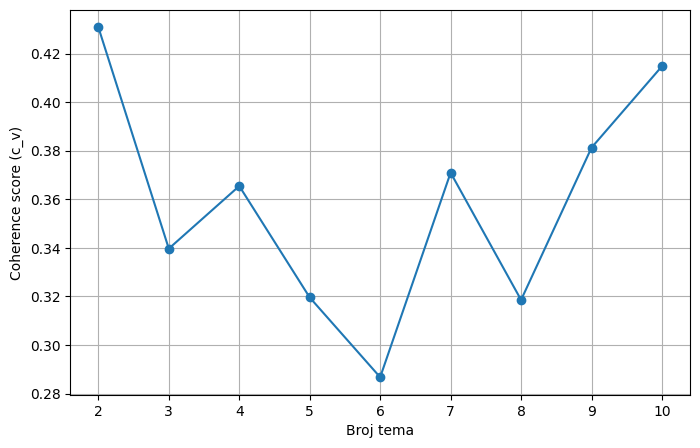

In [37]:
# TODO: Nacrtajte graf (plot) koherencije
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel("Broj tema")
plt.ylabel("Coherence score (c_v)")
plt.grid(True)
plt.show()

In [30]:
# TODO: Odaberite najbolji model na temelju grafa i ispišite teme
optimal_index = coherence_scores.index(max(coherence_scores))
optimal_num_topics = topic_range[optimal_index]

print(f"Optimalan broj tema prema koherenciji: {optimal_num_topics}")
optimal_lda_model = lda_models[optimal_index]

topics = optimal_lda_model.print_topics(num_words=8)
for topic in topics:
    print(topic)

Optimalan broj tema prema koherenciji: 2
(0, '0.029*"know" + 0.021*"court" + 0.021*"open" + 0.021*"father" + 0.021*"conspiracy" + 0.021*"murder" + 0.013*"reveal" + 0.013*"information"')
(1, '0.024*"security" + 0.017*"advocate" + 0.017*"informant" + 0.017*"witness" + 0.017*"special" + 0.017*"service" + 0.017*"father" + 0.017*"material"')


## 6. Sažimanje teksta (Text Summarization)

Sažimanje teksta je proces stvaranja kratkog, točnog i tečnog sažetka dužeg tekstualnog dokumenta. Postoje dva glavna pristupa:
1.  **Ekstraktivno sažimanje**: Odabire najvažnije rečenice iz izvornog teksta i spaja ih u sažetak.
2.  **Apstraktivno sažimanje**: Generira nove rečenice koje prenose glavnu ideju, slično kako to rade ljudi.

U ovoj vježbi ćete implementirati jednostavan **ekstraktivni sažimač** temeljen na frekvenciji riječi. Ideja je da rečenice koje sadrže najčešće riječi (koje nisu stop-riječi) vjerojatno nose najviše informacija.

### Zadatak 3

1. **Dovršite implementaciju** funkcije `summarize_text` u ćeliji ispod.
2. Primijenite funkciju sažimanja na tekst dobiven iz drugog audio uzorka (`clip2.wav`).
3. Usporedite dobiveni sažetak s originalnim tekstom. Je li sažetak uhvatio bitne informacije?
4. **Dodatno:** Pokušajte modificirati funkciju tako da normalizira bodove rečenice s obzirom na duljinu rečenice (kako bi izbjegli favoriziranje dugih rečenica).
5. Ispišite prve 3 rečenice s najvećim značenjem. Može li se iz njih zaključiti o čemu se radi u tekstu?

In [14]:
# Pomoćna funkcija za učitavanje teksta iz klipa
def extract_sentences_from(audio_file):
    text = transcribe_audio_in_chunks(audio_file, recognizer)
    sentences = split_into_sentences(text)
    return sentences

In [32]:
from nltk.probability import FreqDist
from heapq import nlargest

def summarize_text(sentences, num_sentences=3):
    # 1. Izračun frekvencije riječi u cijelom tekstu
    # Spajamo sve rečenice i tokeniziramo ih koristeći preprocess_sentence
    all_words = [word for sentence in sentences for word in preprocess_sentence(sentence)]

    # Izračunajte frekvenciju svake riječi (koristite FreqDist ili običan dictionary)
    freq_dist = FreqDist(all_words)

    # TODO: Normalizacija frekvencija
    # Preko freq_dist.most_common funkcije pronaći maksimalnu frekvenciju pojavljivanja riječi
    # Prođi kroz sve frekvencije riječi u freq_dist i podijeli s maksimalnom frekvencijom
    if not freq_dist:
        return "Nema dovoljno podataka za sažetak."

    max_freq = freq_dist.most_common(1)[0][1]
    for word in freq_dist:
        freq_dist[word] = freq_dist[word] / max_freq

    # 2. Rangiranje rečenica
    sentence_scores = {}

    for sentence in sentences:
        # TODO: Implementirajte logiku bodovanja rečenica
        # 1. Tokenizirajte trenutnu rečenicu (koristite preprocess_sentence)
        # 2. Za svaku riječ u rečenici, ako se riječ nalazi u freq_dist, dodajte njezinu frekvenciju rezultatu rečenice
        # 3. Spremite rezultat u sentence_scores rječnik (ključ=rečenica, vrijednost=bodovi)
        # 4. Normaliziraj s obzirom na duljinu riječi

        words = preprocess_sentence(sentence)
        if not words:
            continue

        score = 0
        for word in words:
            if word in freq_dist:
                score += freq_dist[word]

        sentence_scores[sentence] = score / len(words)

    # 3. Odabir najboljih rečenica
    # Koristimo nlargest za pronalazak rečenica s najvećim brojem bodova
    if not sentence_scores:
        return "Nema dovoljno podataka za sažetak."

    summary_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)
    return " ".join(summary_sentences)


In [39]:
sentences = extract_sentences_from("clip2.wav")
print(sentences)

Speech Recognition could not understand audio in this segment.
['real estate for the closed and open session to review the evidence in Mr older ones case is charged with', 'murder conspiracy to murder conspiracy to cause explosions and possession of explosives before we begin we need to establish the', "order of today's proceedings I would suggest my lawyer that we begin with the opening material and the prosecution I", 'have no preference but I always believed these matters the best left to the wisdom and discretion of the bench', 'we will begin with the clothes materials wig shop we are now in close the crown argue that this evidence', 'should not be disclosed to the defense in the interests of National Security it will be presented for the benefits', 'of the special Advocate I understand that you wish to cross-examine the security service witness whom we will call witnesses', 'of operations think happy thoughts will you confirmed to the special Advocate the identity of the informant

In [40]:
# Testiranje sažimanja na prvom uzorku
# Napomena: Funkcija neće raditi ispravno dok ne implementirate TODO dijelove
try:
    summary = summarize_text(sentences, num_sentences=2)
    print("Izvorni tekst (prvih 200 znakova):")
    full_text = " ".join(sentences)
    print(full_text[:200] + "...")
    print("\nSažetak:")
    print(summary)
except Exception as e:
    print(f"Došlo je do greške (jeste li implementirali funkciju?): {e}")

Izvorni tekst (prvih 200 znakova):
real estate for the closed and open session to review the evidence in Mr older ones case is charged with murder conspiracy to murder conspiracy to cause explosions and possession of explosives before ...

Sažetak:
to reveal his identity in open court knowledge of communications between his father and significant people know and I know you not want the boys role in the rest of his father to be revealed in Open Session because he's


## 7. Apstraktivno sažimanje (Abstractive Summarization)

Za razliku od ekstraktivnog sažimanja koje samo odabire postojeće rečenice, apstraktivno sažimanje generira novi tekst koji parafrazira i sažima izvorni sadržaj. Ovo je složeniji zadatak koji zahtijeva razumijevanje konteksta i semantike.

Danas se za ovaj zadatak najčešće koriste **Transformer** modeli (npr. BART, T5, Pegasus). Koristit ćemo biblioteku `transformers` od Hugging Face-a.

In [18]:
import torch
from transformers import pipeline, AutoTokenizer

# Inicijalizacija pipeline-a za sažimanje
model_name = "facebook/bart-large-cnn"
summarizer = pipeline("summarization", model=model_name)

# Inicijalizacija tokenizatora
tokenizer = AutoTokenizer.from_pretrained(model_name)

full_text = " ".join(sentences)

# Tokenizacija teksta da vidimo koliko tokena ima
# return_tensors="pt" vraća PyTorch tenzore
inputs = tokenizer(full_text, return_tensors="pt", truncation=False)
input_ids = inputs["input_ids"]
num_tokens = input_ids.shape[1]

print(f"Ukupan broj tokena u tekstu: {num_tokens}")

# Limit modela (BART ima limit od 1024 tokena)
max_model_tokens = 1024 - 1

if num_tokens > max_model_tokens:
    print(f"Tekst je predug ({num_tokens} > {max_model_tokens}). Rezanje na {max_model_tokens} tokena.")
    truncated_ids = input_ids[:, :max_model_tokens]
    text_to_summarize = tokenizer.decode(truncated_ids[0], skip_special_tokens=True)
else:
    text_to_summarize = full_text

print(f"Duljina teksta za sažimanje (znakovi): {len(text_to_summarize)}")

# Generiranje sažetka
try:
    summary_abstractive = summarizer(text_to_summarize, max_length=150, min_length=40, do_sample=False)
    print("\n--- Apstraktivni sažetak ---")
    print(summary_abstractive[0]['summary_text'])
except Exception as e:
    print(f"Došlo je do greške prilikom sažimanja: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Ukupan broj tokena u tekstu: 312
Duljina teksta za sažimanje (znakovi): 1739

--- Apstraktivni sažetak ---
Mr Edwin's 14 year old son Amir is the informant in the case. The crown argue that this evidence should not be disclosed to the defense in the interests of National Security it will be presented for the benefits of the special Advocate. The identity of the informant has not been confirmed.


### Zadatak 4

1. Pokrenite kod u ćeliji iznad
2. Proučite izlaz
3. Interpretirajte jesu li rezultati sažetka išta bolji od prijašnjeg pristupa brojanja frekvencija rijeći u rečenicama?
4. Zapišite zapažanja

Napisani sažetak pomoću apstraktivnog sažimanja je puno jasniji i moguće je odmah zaključiti o ćemu se radi, opis je puno detaljniji. Kod početne tehnike sažimanja pomoću brojanja frekvencije riječi može se "nabosti" o ćemu se radi u tekstu, ali radnja i odnos među subjektima nije dovljno jasan da bi se moglo defnirati što je sama tema i bit teksta.